# __TelecomX - Parte 2: Modelos de prediccion__

## __Objetivo__

La empresa busca anticiparse al problema de cancelacion de clientes, por lo que vamos a construir un pipeline robusto para la etapa inicial del modelado cuyas tareas son lo siguiente:

- Preparar los datos (limpieza, codificacion y normalizacion).
- Realizar analisis de correlacion y seleccion de variables.
- Entrenar diferentes modelos de clasificacion, evaluar el rendimiento a traves de distintas metricas e interpretar los resultados de cada uno.
- Crear un reporte con algunas recomendaciones sobre los principales factores que influyen en la cancelacion de clientes.

## __Importar Librerias__

In [1]:
import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap

import warnings
#import requests
import pickle

from timeit import default_timer as timer
from datetime import datetime

import imblearn
from imblearn.under_sampling import NearMiss
from imblearn.over_sampling import SMOTENC

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold, cross_validate, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, RocCurveDisplay, precision_recall_curve
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, MinMaxScaler, StandardScaler, RobustScaler
from sklearn.compose import make_column_transformer
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier as knn
from sklearn.svm import SVC
from sklearn.inspection import permutation_importance

import xgboost
from xgboost import XGBClassifier

In [2]:
# version de las libreria utilizadas
print(f'numpy=={np.__version__}')
print(f'pandas=={pd.__version__}')
print(f'matplotlib=={matplotlib.__version__}')
print(f'seaborn=={sns.__version__}')
print(f'scikit-learn=={sklearn.__version__}')
print(f'imblearn=={sklearn.__version__}')
print(f'xgboost=={xgboost.__version__}')

numpy==2.2.6
pandas==2.3.1
matplotlib==3.10.3
seaborn==0.13.2
scikit-learn==1.6.1
imblearn==1.6.1
xgboost==3.0.5


## __Importar datos__

In [3]:
# cargar datos preprocesados desde GitHub
data = pd.read_csv('https://raw.githubusercontent.com/jbernalg/challenge_TelecomX/refs/heads/main/data_out/datos_tratados.csv', sep=',')
data.head()

,cancelacion,genero,jubilado,en_pareja,dependientes,meses_contrato,servicio_telefonico,multiples_lineas,servicio_internet,seguridad_online,...,proteccion_dispositivo,soporte_efectivo,streaming_TV,streaming_peliculas,tipo_contrato,facturacion_electronica,metodo_pago,cuenta_mensual,cuentas_total,cuentas_diarias
0,0,Femenino,No,Si,Si,9,Si,No,DSL,No,...,No,Si,Si,No,un year,Si,cheque por correo,65.6,593.30,0.242963
1,0,Masculino,No,No,No,9,Si,Si,DSL,No,...,No,No,No,Si,mes a mes,No,cheque por correo,59.9,542.40,0.221852
2,1,Masculino,No,No,No,4,Si,No,Fibra_optica,No,...,Si,No,No,No,mes a mes,Si,cheque electronico,73.9,280.85,0.615833
3,1,Masculino,Si,Si,No,13,Si,No,Fibra_optica,No,...,Si,No,Si,Si,mes a mes,Si,cheque electronico,98.0,1237.85,0.251282
4,1,Femenino,Si,Si,No,3,Si,No,Fibra_optica,No,...,No,Si,Si,No,mes a mes,Si,cheque por correo,83.9,267.40,0.932222


> Vamos a eliminar la variable _cuentas_diarias_ debido a que fue obtenida a partir de _cuenta_mensual_ por lo que no aporta informacion relevante.

In [4]:
datos = data.drop(['cuentas_diarias'], axis=1)
datos.head()

,cancelacion,genero,jubilado,en_pareja,dependientes,meses_contrato,servicio_telefonico,multiples_lineas,servicio_internet,seguridad_online,respaldo_online,proteccion_dispositivo,soporte_efectivo,streaming_TV,streaming_peliculas,tipo_contrato,facturacion_electronica,metodo_pago,cuenta_mensual,cuentas_total
0,0,Femenino,No,Si,Si,9,Si,No,DSL,No,Si,No,Si,Si,No,un year,Si,cheque por correo,65.6,593.30
1,0,Masculino,No,No,No,9,Si,Si,DSL,No,No,No,No,No,Si,mes a mes,No,cheque por correo,59.9,542.40
2,1,Masculino,No,No,No,4,Si,No,Fibra_optica,No,No,Si,No,No,No,mes a mes,Si,cheque electronico,73.9,280.85
3,1,Masculino,Si,Si,No,13,Si,No,Fibra_optica,No,Si,Si,No,Si,Si,mes a mes,Si,cheque electronico,98.0,1237.85
4,1,Femenino,Si,Si,No,3,Si,No,Fibra_optica,No,No,No,Si,Si,No,mes a mes,Si,cheque por correo,83.9,267.40


In [5]:
# resumen estadistico de las variables numericas
datos.describe()

,cancelacion,meses_contrato,cuenta_mensual,cuentas_total
count,7032.000000,7032.000000,7032.000000,7032.000000
mean,0.265785,32.421786,64.798208,2283.300441
std,0.441782,24.545260,30.085974,2266.771362
min,0.000000,1.000000,18.250000,18.800000
25%,0.000000,9.000000,35.587500,401.450000
50%,0.000000,29.000000,70.350000,1397.475000
75%,1.000000,55.000000,89.862500,3794.737500
max,1.000000,72.000000,118.750000,8684.800000


In [6]:
datos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7032 entries, 0 to 7031
Data columns (total 20 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   cancelacion              7032 non-null   int64  
 1   genero                   7032 non-null   object 
 2   jubilado                 7032 non-null   object 
 3   en_pareja                7032 non-null   object 
 4   dependientes             7032 non-null   object 
 5   meses_contrato           7032 non-null   int64  
 6   servicio_telefonico      7032 non-null   object 
 7   multiples_lineas         7032 non-null   object 
 8   servicio_internet        7032 non-null   object 
 9   seguridad_online         7032 non-null   object 
 10  respaldo_online          7032 non-null   object 
 11  proteccion_dispositivo   7032 non-null   object 
 12  soporte_efectivo         7032 non-null   object 
 13  streaming_TV             7032 non-null   object 
 14  streaming_peliculas     

## __Encoding de variables categoricas__

In [7]:
datos.columns

Index(['cancelacion', 'genero', 'jubilado', 'en_pareja', 'dependientes',
       'meses_contrato', 'servicio_telefonico', 'multiples_lineas',
       'servicio_internet', 'seguridad_online', 'respaldo_online',
       'proteccion_dispositivo', 'soporte_efectivo', 'streaming_TV',
       'streaming_peliculas', 'tipo_contrato', 'facturacion_electronica',
       'metodo_pago', 'cuenta_mensual', 'cuentas_total'],
      dtype='object')

In [8]:
# definir variables predictoras
X = datos.drop('cancelacion', axis=1)
# definir variable target
y = datos['cancelacion']

Vamos a crear un df llamado _df_linear_ el cual contendra las variables categoricas con `one_hot_encoder(drop='first')` y variables numericas escaladas para modelos sensibles a escalas y multicolinealidad. Con ello se busca evitar la "trampa de las variables ficticias" eliminando la primera categoría de cada variable.

In [9]:
X_linear = X.copy()
y_linear = y.copy()

In [10]:
# seleccionar variables categoricas manualmente
categoricas = ['genero', 'jubilado', 'en_pareja', 'dependientes', 'servicio_telefonico',
               'multiples_lineas', 'servicio_internet', 'seguridad_online', 'respaldo_online',
               'proteccion_dispositivo', 'soporte_efectivo', 'streaming_TV', 'streaming_peliculas', 
               'tipo_contrato', 'facturacion_electronica', 'metodo_pago']

In [11]:
one_hot_linear = make_column_transformer(
    (OneHotEncoder(drop='first'), categoricas),
    remainder='passthrough',
    sparse_threshold=0,
    force_int_remainder_cols=False # mantiene el nombre de las variables que no transforma
)

label_encoder = LabelEncoder()

In [12]:
X_linear = one_hot_linear.fit_transform(X_linear)
y_linear = label_encoder.fit_transform(y_linear)

In [13]:
columnas = one_hot_linear.get_feature_names_out()

columnas_encoded = []
for columna in columnas:
    columna = columna.split('__')[1]
    columnas_encoded.append(columna)

In [14]:
df_linear = pd.DataFrame(X_linear, columns=columnas_encoded)
df_y_linear = pd.DataFrame(y_linear, columns=['cancelacion'])
df_linear = pd.concat([df_linear, df_y_linear], axis=1)
df_linear.head()

,genero_Masculino,jubilado_Si,en_pareja_Si,dependientes_Si,servicio_telefonico_Si,multiples_lineas_Si,multiples_lineas_sin servicio teleonico,servicio_internet_Fibra_optica,servicio_internet_No,seguridad_online_Si,...,tipo_contrato_mes a mes,tipo_contrato_un year,facturacion_electronica_Si,metodo_pago_cheque por correo,metodo_pago_tarjeta de credito,metodo_pago_transferencia,meses_contrato,cuenta_mensual,cuentas_total,cancelacion
0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,1.0,1.0,0.0,0.0,9.0,65.6,593.30,0
1,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,9.0,59.9,542.40,0
2,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,1.0,0.0,1.0,0.0,0.0,0.0,4.0,73.9,280.85,1
3,1.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,1.0,0.0,1.0,0.0,0.0,0.0,13.0,98.0,1237.85,1
4,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,1.0,0.0,1.0,1.0,0.0,0.0,3.0,83.9,267.40,1


Ahora, vamos a crear un df llamado _df_ el cual contendra las variables categoricas codificadas con `one_hot_encoder(drop=if_binary)` y las variables numericas sin escalar para modelos robustos a escalas y multicolinealidad. Con ello se busca eliminar una categoria cuando la variable presenta 2 para asi evitar multicolinealidad. Util en modelos lineales.

In [15]:
one_hot = make_column_transformer(
    (OneHotEncoder(drop='if_binary'), categoricas),
    remainder = 'passthrough',
    sparse_threshold=0,
    force_int_remainder_cols=False
)

label_encoder = LabelEncoder()

In [16]:
X = one_hot.fit_transform(X)
y = label_encoder.fit_transform(y)

In [17]:
columnas = one_hot.get_feature_names_out()

columnas_encoded = []
for columna in columnas:
    columna = columna.split('__')[1]
    columnas_encoded.append(columna)

In [18]:
df = pd.DataFrame(X, columns=columnas_encoded)
df_y = pd.DataFrame(y, columns=['cancelacion'])
df = pd.concat([df, df_y], axis=1)
df.head()

,genero_Masculino,jubilado_Si,en_pareja_Si,dependientes_Si,servicio_telefonico_Si,multiples_lineas_No,multiples_lineas_Si,multiples_lineas_sin servicio teleonico,servicio_internet_DSL,servicio_internet_Fibra_optica,...,tipo_contrato_un year,facturacion_electronica_Si,metodo_pago_cheque electronico,metodo_pago_cheque por correo,metodo_pago_tarjeta de credito,metodo_pago_transferencia,meses_contrato,cuenta_mensual,cuentas_total,cancelacion
0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,...,1.0,1.0,0.0,1.0,0.0,0.0,9.0,65.6,593.30,0
1,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,9.0,59.9,542.40,0
2,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,...,0.0,1.0,1.0,0.0,0.0,0.0,4.0,73.9,280.85,1
3,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,...,0.0,1.0,1.0,0.0,0.0,0.0,13.0,98.0,1237.85,1
4,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,1.0,0.0,0.0,3.0,83.9,267.40,1


Vamos a definir un tercer df llamado _df_scale_ el cual contendra las variables categoricas codigicadas con `one_hot_encoder(drop=if_binary)` y variables numericas escalada para modelos robustos a multicolinealidad pero sensibles a escalas de los datos

In [19]:
df_scale = df.copy()

## __Normalizacion de datos__

Como vamos a probar distintos modelos, analizaremos las variables numericas. Ademas, haremos una normalizacion para aquellos modelos que lo requieran

In [20]:
# funcion que implementa la regla Freedman-Diaconis para calcular el ancho optimo
# de los bins
def bin_width(df, columna):
    n = df.shape[0]
    iqr = df[columna].quantile(0.75) - df[columna].quantile(0.25)
    bin_width = 2*(iqr/np.cbrt(n))
    return bin_width

In [21]:
# definimos los objetos Scaler para cada variable numerica

# StandarScaler usa media y STD lo que lo hace sensible a outliers
scaler_meses_contrato = StandardScaler()
scaler_cuenta_mensual = StandardScaler()
scaler_cuentas_total = StandardScaler()

# RobustScaler usa la mediana y el IQR lo que lo hace resistente a outliers
robust_meses_contrato = RobustScaler()
robust_cuenta_mensual = RobustScaler()
robust_cuentas_total = RobustScaler()

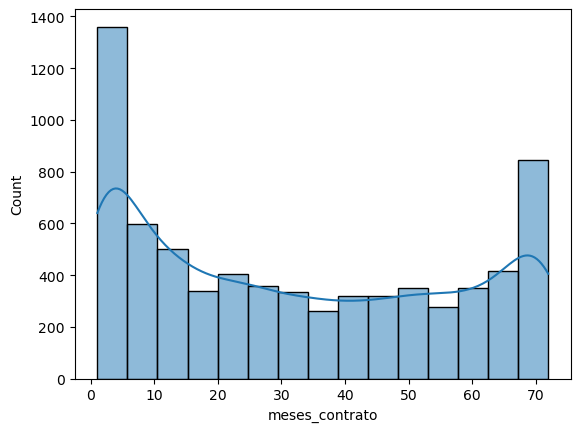

In [22]:
BIN_WIDTH = bin_width(df, 'meses_contrato')

sns.histplot(df['meses_contrato'], binwidth=BIN_WIDTH, kde=True)
plt.show()

- Claramente vemos que la distribucion _meses_contrato_ es bimodal. Vamos a aplicar diferentes transformaciones para buscar llevarlo a un comportamiento lineal